# Loading Packages

In [ ]:
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import KFold

# Data Preprocessing

In [ ]:
hist = pd.read_csv('Property_Assessment_Data__Historical_.csv') # Historical data.
re_data = pd.read_csv('EdmontonRealEstateData.csv') # Real estate (main) data.

Retrieve the assessed value in 2016 from the historical data set and join to provided data set using the account/taxroll number. I have assumed that re_data already contains the assessed value for 2015.

In [ ]:
hist_2016 = hist[hist['Assessment Year'] == 2016][['Account Number', 'Assessed Value']].rename(columns={'Assessed Value': 'Assessed Value 2016'})
hist_2016 = hist_2016.set_index('Account Number')

In [ ]:
re_data_ext = re_data.set_index('taxroll_number').join(hist_2016) # The data now contains a column for the assessed value in 2016.
re_data_ext.head()

,landuse_description,building_name,market_building_class,property_type,effective_build_year,net_area,basement_finished,has_garage,has_fireplace,assessed_value,house_suit,house_number,house_suff,street_name,postal_code,city,full_address,neighbourhood,fully_taxable,fully_complete,lot_size,building_count,build_year_mbc,walkout_basement,air_conditioning,valuation_group,display_type,site_coverage,tot_gross_area_description,geometry,result_code,result_message,result_description,lon,lat,Assessed Value 2016
taxroll_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10195787,100% TELEPHONE/TELEGRAPH - OTHER,TELUS COMM STATION,COMPUTER CENTER,URBAN,2012,139.54,NO,NO,NO,331000,NaN,5904.0,NaN,10 AVENUE SW,T6X0T1,EDMONTON,5904 10 AVENUE SW EDMONTON AB T6X 0T1,WALKER,Yes,Yes,832.413 M2 / 8960 FT2 / .206 AC,1,"2012, COMPUTER CENTER",NO,Yes,SPECIAL PURPOSE,NONRES,17%,139.54 M2 / 1502 FT2,"{\type\"": \""Polygon\"",\""coordinates\"":[[[37824...",1110,Assessment found,NaN,-113.430747,53.424591,"347,000.00"
10195786,100% SINGLE FAMILY DWELLING,NaN,2 STOREY WITH BASEMENT,RESIDENTIAL,2011,188.50,Yes,Yes,Yes,470500,NaN,5908.0,NaN,10 AVENUE SW,T6X0T1,EDMONTON,5908 10 AVENUE SW EDMONTON AB T6X 0T1,WALKER,Yes,Yes,482.279 M2 / 5191.2 FT2 / .119 AC,1,"2011, 2 STOREY WITH BASEMENT",NO,NO,RESIDENTIAL SOUTH,RES,25%,227.5 M2 / 2448.8 FT2,"{\type\"": \""Polygon\"",\""coordinates\"":[[[37833...",1110,Assessment found,NaN,-113.430993,53.424599,"483,000.00"
10195785,100% SINGLE FAMILY DWELLING,NaN,2 STOREY WITH BASEMENT,RESIDENTIAL,2011,178.00,NO,Yes,Yes,442500,NaN,5912.0,NaN,10 AVENUE SW,T6X0T1,EDMONTON,5912 10 AVENUE SW EDMONTON AB T6X 0T1,WALKER,Yes,Yes,396.875 M2 / 4271.9 FT2 / .098 AC,1,"2011, 2 STOREY WITH BASEMENT",NO,NO,RESIDENTIAL SOUTH,RES,29%,215.6 M2 / 2320.7 FT2,"{\type\"": \""Polygon\"",\""coordinates\"":[[[37812...",1110,Assessment found,NaN,-113.431231,53.424560,"453,500.00"
10195784,100% SINGLE FAMILY DWELLING,NaN,2 STOREY WITH BASEMENT,RESIDENTIAL,2011,178.30,NO,Yes,Yes,448000,NaN,5916.0,NaN,10 AVENUE SW,T6X0T1,EDMONTON,5916 10 AVENUE SW EDMONTON AB T6X 0T1,WALKER,Yes,Yes,403.359 M2 / 4341.7 FT2 / .1 AC,1,"2011, 2 STOREY WITH BASEMENT",NO,NO,RESIDENTIAL SOUTH,RES,31%,217.1 M2 / 2336.8 FT2,"{\type\"": \""Polygon\"",\""coordinates\"":[[[37799...",1110,Assessment found,NaN,-113.431416,53.424549,"458,000.00"
10195783,100% SINGLE FAMILY DWELLING,NaN,2 STOREY WITH BASEMENT,RESIDENTIAL,2010,182.80,NO,Yes,Yes,447500,NaN,5920.0,NaN,10 AVENUE SW,T6X0T1,EDMONTON,5920 10 AVENUE SW EDMONTON AB T6X 0T1,WALKER,Yes,Yes,375.192 M2 / 4038.5 FT2 / .093 AC,1,"2010, 2 STOREY WITH BASEMENT",NO,NO,RESIDENTIAL SOUTH,RES,33%,226 M2 / 2432.6 FT2,"{\type\"": \""Polygon\"",\""coordinates\"":[[[37788...",1110,Assessment found,NaN,-113.431578,53.424548,"468,000.00"


In [ ]:
Data = re_data_ext[['landuse_description', 'market_building_class', 'property_type', 'effective_build_year', 'net_area', 'basement_finished', 'has_garage', 'has_fireplace', 'assessed_value',
                    'fully_taxable', 'fully_complete', 'building_count', 'walkout_basement', 'air_conditioning', 'valuation_group','display_type',	'site_coverage', 'lon',	'lat'	,'Assessed Value 2016']]

In [ ]:
Data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Data = Data.loc[(Data['property_type']=='RESIDENTIAL') & (Data['display_type']=='RES')]
len(Data)

50506

In [ ]:
Data.drop(['property_type', 'display_type'], axis =1, inplace=True)
Data.head()

,landuse_description,market_building_class,effective_build_year,net_area,basement_finished,has_garage,has_fireplace,assessed_value,fully_taxable,fully_complete,building_count,walkout_basement,air_conditioning,valuation_group,site_coverage,lon,lat,Assessed Value 2016
taxroll_number,,,,,,,,,,,,,,,,,,
10195786,100% SINGLE FAMILY DWELLING,2 STOREY WITH BASEMENT,2011,188.5,Yes,Yes,Yes,470500,Yes,Yes,1,NO,NO,RESIDENTIAL SOUTH,25%,-113.430993,53.424599,"483,000.00"
10195785,100% SINGLE FAMILY DWELLING,2 STOREY WITH BASEMENT,2011,178.0,NO,Yes,Yes,442500,Yes,Yes,1,NO,NO,RESIDENTIAL SOUTH,29%,-113.431231,53.424560,"453,500.00"
10195784,100% SINGLE FAMILY DWELLING,2 STOREY WITH BASEMENT,2011,178.3,NO,Yes,Yes,448000,Yes,Yes,1,NO,NO,RESIDENTIAL SOUTH,31%,-113.431416,53.424549,"458,000.00"
10195783,100% SINGLE FAMILY DWELLING,2 STOREY WITH BASEMENT,2010,182.8,NO,Yes,Yes,447500,Yes,Yes,1,NO,NO,RESIDENTIAL SOUTH,33%,-113.431578,53.424548,"468,000.00"
10195782,100% SINGLE FAMILY DWELLING,2 STOREY WITH BASEMENT,2010,208.3,NO,Yes,Yes,469500,Yes,Yes,1,NO,NO,RESIDENTIAL SOUTH,34%,-113.431742,53.424544,"479,500.00"


# Adding a column showing +1 for price increase and -1 otherwise

In [ ]:
# Some type conversion.
Data.loc[:, 'effective_build_year'] = Data['effective_build_year'].astype('float64')
Data.loc[:, 'assessed_value'] = Data['assessed_value'].astype('float64')
Data.loc[:, 'building_count'] = Data['building_count'].astype('float64')
# The below line seems overly complicated but gets rid of the comma so that we can convert from type object to a float.
Data.loc[:, 'Assessed Value 2016'] = Data.loc[:, 'Assessed Value 2016'].apply(lambda x: float(x.replace(',','')))
Data.loc[:, 'site_coverage'] = Data.loc[:, 'site_coverage'].apply(lambda x: float(x.replace('%','')))


In [ ]:
Data['Price Increase']=0

for i in range(len(Data)):
  if Data['Assessed Value 2016'].iloc[i]> Data['assessed_value'].iloc[i]:
    Data['Price Increase'].iloc[i] = 1
  else:
    Data['Price Increase'].iloc[i] = -1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Deep Neural Network

In [ ]:
#Mapping categorical variables to numbers
Data['air_conditioning']  = Data['air_conditioning'].map({'NO':0, 'Yes':1})
Data['walkout_basement']  = Data['walkout_basement'].map({'NO':0, 'Yes':1})
Data['fully_taxable']  = Data['fully_taxable'].map({'NO':0, 'Yes':1})

Data['has_fireplace']  = Data['has_fireplace'].map({'NO':0, 'Yes':1})

Data['has_garage']  = Data['has_garage'].map({'NO':0, 'Yes':1})

Data['basement_finished']  = Data['basement_finished'].map({'NO':0, 'Yes':1})

Data['fully_complete']  = Data['fully_complete'].map({'NO':0, 'Yes':1})

Data['valuation_group']  = Data['valuation_group'].map({'RESIDENTIAL SOUTH':0, 'RESIDENTIAL NORTH':1, 'RESIDENTIAL WC':2,
       'RESIDENTIAL RIVVAL':3, 'SPECIAL PURPOSE':4, 'LAND': 5, 'RESIDENTIAL LAND':6})

In [ ]:
#Mapping non-number values
Data['landuse_description']  = Data['landuse_description'].map({'100% SINGLE FAMILY DWELLING':0,
                                                                '100% SEM-DETACHED DWELLING (DUPLEX)':1,
                                                                '100% ONE FAMILY DWELLING WITH SUITE':2,
                                                                '100% DUPLEX - SIDE BY SIDE':3,
                                                                '100% SEMI DETACHED DWLG WITH SUITE (DUPLEX)':4,
                                                                '100% SEMI-DETACHED DWELLING (FOUR-PLEX OR MORE)':5,
                                                                '100% SEMI-DETACHED DWELLING (TRI-PLEX)':6,
                                                                '100% DUPLEX SIDE BY SIDE LOWER LEVEL UNITS':7,
                                                                '100% CO-OP/NON-PRO HOUSING DETACHUNIT':8,
                                                                '100% HOUSE 3 OR LESS RENTAL SELF-CONTAINED UNITS':9,
                                                                '100% THREE/FOUR FAMILY DWELLING-OTHER':10,
                                                                '100% HOUSE 4 OR MORE RENTAL SELF-CONTAINED UNITS':11,
                                                                '100% OTHER TWO FAMILY DWELLING':12,
                                                                '100% TRI-PLEX':13,
                                                                '100% HANDICAPPED HOME':14,
                                                                '100% DERELICT RESIDENTIAL':15,
                                                                '100% DUPLEX - UP AND DOWN':16,
                                                                '100% DUPLEX UP AND DOWN LOWER LEVEL UNITS':17,
                                                                '100% CONVENT/SEMINARY':18,
                                                                '100% 2 OR MORE FAMILY UNITS ON 1 PCL':19,
                                                                '55% SINGLE FAMILY DWELLING|45% COMM BUSINESS/SERVICE - OTHER':20,
                                                                '75% SINGLE FAMILY DWELLING|25% ONE STOREY OFFICE':21,
                                                                '71% SINGLE FAMILY DWELLING|29% COMM BUSINESS/SERVICE - OTHER':22,
                                                                '100% ONE DWELLING UNIT ACCESSORY BLDG':23,
                                                                '80% SINGLE FAMILY DWELLING|20% NONFRMLD W OTHER BLDGS':24,
                                                                '67% SINGLE FAMILY DWELLING|33% NONFRMLD W OTHER BLDGS':25,
                                                                '94% SINGLE FAMILY DWELLING|6% COMM BUSINESS/SERVICE - OTHER':26,
                                                                '100% DUPLEX BACK TO BACK LOWER LEVEL UNITS':27
                                                                })

Data['market_building_class']  = Data['market_building_class'].map({'2 STOREY WITH BASEMENT':0,
                                                                '2 STOREY DUPLEX WITH A BASEMENT':1,
                                                                'BI-LEVEL':2,
                                                                'BUNGALOW BASEMENTLESS':3,
                                                                'BUNGALOW WITH BASEMENT':4,
                                                                '2 1/2 STORY':5,
                                                                'SPLIT LEVEL':6,
                                                                '1 1/2 STOREY WITH BASEMENT':7,
                                                                'DUPLEX BI-LEVEL':8,
                                                                '1 STOREY DUPLEX WITH BASEMENT':9,
                                                                '2 STOREY BASEMENTLESS':10,
                                                                'SPLIT LEVEL WITH CRAWL':11,
                                                                '2STOREY MULTI SIDE X SIDE WITH BASEMENT':12,
                                                                '1 3/4 STOREY WITH BASEMENT':13,
                                                                '1 3/4 STOREY WITHOUT A BASEMENT':14,
                                                                '2 1/2 STORY BASEMENTLESS':15,
                                                                '3 STOREY WITH BASEMENT':16,
                                                                '3 STORY':17,
                                                                '1 1/2 STOREY BASEMENTLESS':18,
                                                                'MULTIPLE SIDE BY SIDE WITH BASEMENT':19,
                                                                'DUPLEX SPLIT LEVEL':20,
                                                                '2 STOREY FOUR-PLEX WITH BASEMENT':21,
                                                                'CHURCH EDUCATIONAL WINGS':22,
                                                                'MULTI SIDE X SIDE BI LEVEL':23,
                                                                'CEDAR LOG 1 1/2 STOREY WITH BASEMENT':24,
                                                                '2 STOREY DUPLEX BASEMENTLESS':25,
                                                                '1 STOREY DUPLEX BASEMENTLESS':26,
                                                                '1 STOREY FOUR-PLEX WITH BASEMENT':27,
                                                                '3 STOREY BASEMENTLESS':28,
                                                                'STORAGE GARAGE':29,
                                                                'DUPLEX SPLIT LEVEL WITH CRAWL':30,
                                                                'CEDAR LOG 1 STOREY WITH BASEMENT':31,
                                                                'CEDAR LOG BILEVEL':32,
                                                                '3 STOREY DUPLEX WITH BASEMENT':33,
                                                                '3 STOREY MULTI SIDE X SIDE WITH BASEMENT':34,
                                                                'ROWHOUSING':35,
                                                                'MOBILE HOME SINGLE WITH BASEMENT':36,
                                                                'MOBILE HOME SINGLE WIDE BASEMENTLESS':37
                                                                })

In [ ]:
Data=Data[Data['assessed_value']!=0]

In [ ]:
# removing outliers
z= np.abs(stats.zscore(Data['assessed_value'])) # Utilizing zscore to remove outliers
filtered_df = (z < 3) # Removing values with zscore greater than 3 standard deviation
Data = Data[filtered_df] # Filtered data set with removed outliers
Data

,landuse_description,market_building_class,effective_build_year,net_area,basement_finished,has_garage,has_fireplace,assessed_value,fully_taxable,fully_complete,building_count,walkout_basement,air_conditioning,valuation_group,site_coverage,lon,lat,Assessed Value 2016,Price Increase
taxroll_number,,,,,,,,,,,,,,,,,,,
10195786,0.0,0.0,2011.0,188.50,1,1,1,470500.0,1,1,1.0,0,0,0,25.0,-113.430993,53.424599,483000.0,1
10195785,0.0,0.0,2011.0,178.00,0,1,1,442500.0,1,1,1.0,0,0,0,29.0,-113.431231,53.424560,453500.0,1
10195784,0.0,0.0,2011.0,178.30,0,1,1,448000.0,1,1,1.0,0,0,0,31.0,-113.431416,53.424549,458000.0,1
10195783,0.0,0.0,2010.0,182.80,0,1,1,447500.0,1,1,1.0,0,0,0,33.0,-113.431578,53.424548,468000.0,1
10195782,0.0,0.0,2010.0,208.30,0,1,1,469500.0,1,1,1.0,0,0,0,34.0,-113.431742,53.424544,479500.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952730,0.0,4.0,2001.0,153.60,1,1,1,772000.0,1,1,1.0,0,0,1,2.0,-113.323203,53.679244,727000.0,-1
9952732,0.0,4.0,1998.0,169.60,1,1,1,788500.0,1,1,1.0,0,0,1,2.0,-113.322486,53.679981,730000.0,-1
9952733,0.0,0.0,1998.0,253.60,0,1,1,752000.0,1,1,1.0,0,0,1,2.0,-113.321340,53.680806,705000.0,-1


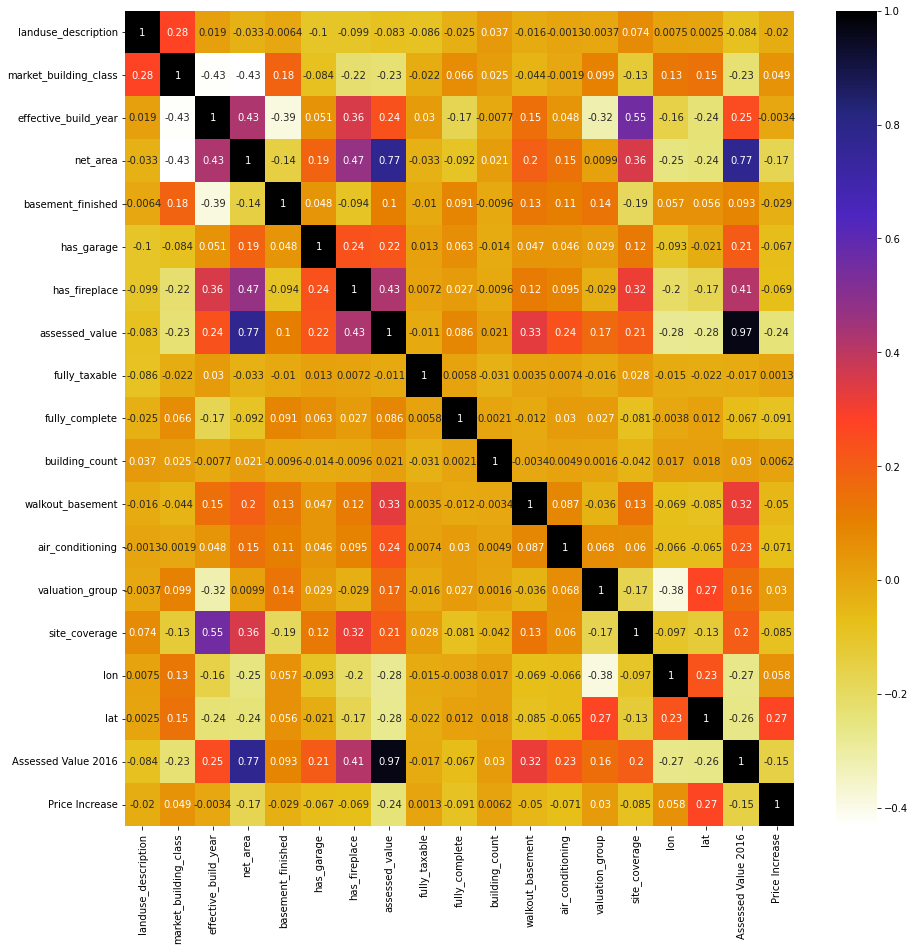

In [ ]:
#Using Pearson Correlation between featurs and output
plt.figure(figsize=(15,15))
cor = Data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
len(Data)

49728

In [ ]:
y = Data.loc[:,'assessed_value'].copy()

In [ ]:
scaler = MinMaxScaler()
numerical = Data.select_dtypes(include='float64').columns
Data.loc[:,numerical]=scaler.fit_transform(Data.loc[:,numerical])

In [ ]:
Data['assessed_value']=y
Data.to_csv('House_Data.csv')

In [ ]:
X_scaled = Data.drop(['assessed_value', 'Assessed Value 2016', 'Price Increase', 'fully_taxable'], axis =1)
#'assessed_value', 'Assessed Value 2016', 'Price Increase', 'has_fireplace', 'fully_taxable'
#'assessed_value', 'Assessed Value 2016', 'Price Increase', 'fully_taxable', 'basement_finished', 'lon', 'lat'
#y = Data.loc[:,'assessed_value']

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=2)

In [ ]:
class Datasetload(Dataset):

    def __init__(self, x, y):
        self.df = pd.concat([y, x], axis=1)
        self.data = self.df.to_numpy()
        self.x , self.y = (torch.from_numpy(self.data[:,1:]),
                           torch.from_numpy(self.data[:,0]))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        return self.x[index, :], self.y[index]

In [ ]:
train_dataset = Datasetload(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x



model = Model(input_dim=15).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

In [ ]:
#X_train = Variable(torch.tensor(X_train.to_numpy())).float().to(device)
#y_train = Variable(torch.tensor(y_train.to_numpy())).long().to(device)
X_test  = Variable(torch.tensor(X_test.to_numpy())).float().to(device)
y_test  = Variable(torch.tensor(y_test.to_numpy())).long().to(device)

# 5-Fold Cross-Validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

EPOCHS = 250

test_MSE_k_all = []
test_MAPE_k_all = []

for train_index, test_index in kfold.split(X_train):
  Xi_train_kfold, Xi_test_kfold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]

  yi_train_kfold, yi_test_kfold = y_train.iloc[train_index], y_train.iloc[test_index]

  train_dataset_kfold = Datasetload(Xi_train_kfold, yi_train_kfold)
  train_loader_kfold = DataLoader(train_dataset_kfold, batch_size=128, shuffle=True)

  Xi_test_kfold  = Variable(torch.tensor(Xi_test_kfold.to_numpy())).float().to(device)
  yi_test_kfold  = Variable(torch.tensor(yi_test_kfold.to_numpy())).long().to(device)


  for epoch in range(EPOCHS):
    for data in train_loader_kfold:
      My_X, My_y=data

      optimizer.zero_grad()
      y_pred = model(My_X.view(-1, 15).float())
      new_shape = (len(y_pred), 1)
      loss = loss_fn(y_pred.view(-1), My_y.view(-1).float()) #loss(input, target)
      loss.backward()
      optimizer.step()


  y_test_pred_K = model(Xi_test_kfold)
  test_MSE_k = loss_fn(y_test_pred_K.view(-1), yi_test_kfold.view(-1))
  test_MSE_k_all.append(test_MSE_k)

  MAPE_test=sklearn.metrics.mean_absolute_percentage_error(yi_test_kfold.view(-1).cpu().data.numpy(), y_test_pred_K.view(-1).cpu().data.numpy())
  test_MAPE_k_all.append(MAPE_test)


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

EPOCHS = 250

test_MSE_k_all = []
test_MAPE_k_all = []

best_model = None
best_avg_MSE = np.inf

for train_index, test_index in kfold.split(X_train):
    Xi_train_kfold, Xi_test_kfold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    yi_train_kfold, yi_test_kfold = y_train.iloc[train_index], y_train.iloc[test_index]

    train_dataset_kfold = Datasetload(Xi_train_kfold, yi_train_kfold)
    train_loader_kfold = DataLoader(train_dataset_kfold, batch_size=128, shuffle=True)

    Xi_test_kfold = Variable(torch.tensor(Xi_test_kfold.to_numpy())).float().to(device)
    yi_test_kfold = Variable(torch.tensor(yi_test_kfold.to_numpy())).long().to(device)

    for epoch in range(EPOCHS):
        for data in train_loader_kfold:
            My_X, My_y = data

            optimizer.zero_grad()
            y_pred = model(My_X.view(-1, 15).float())
            new_shape = (len(y_pred), 1)
            loss = loss_fn(y_pred.view(-1), My_y.view(-1).float()) #loss(input, target)
            loss.backward()
            optimizer.step()

    y_test_pred_K = model(Xi_test_kfold)
    test_MSE_k = loss_fn(y_test_pred_K.view(-1), yi_test_kfold.view(-1))
    test_MSE_k_all.append(test_MSE_k)

    MAPE_test = sklearn.metrics.mean_absolute_percentage_error(yi_test_kfold.view(-1).cpu().data.numpy(), y_test_pred_K.view(-1).cpu().data.numpy())
    test_MAPE_k_all.append(MAPE_test)

    if test_MSE_k < best_avg_MSE:
        best_model = model.state_dict()
        best_avg_MSE = test_MSE_k

# Use the best model based on the lowest average MSE
model.load_state_dict(best_model)

# Access the best MSE value and index
best_MSE = min(test_MSE_k_all)
best_MSE_index = test_MSE_k_all.index(best_MSE)


In [ ]:
test_MSE_k_all

[tensor(3.4847e+09, grad_fn=<MseLossBackward0>),
 tensor(3.3626e+09, grad_fn=<MseLossBackward0>),
 tensor(3.5548e+09, grad_fn=<MseLossBackward0>),
 tensor(2.8268e+09, grad_fn=<MseLossBackward0>),
 tensor(2.6368e+09, grad_fn=<MseLossBackward0>)]

In [ ]:
torch.mean(torch.stack(test_MSE_k_all))

tensor(3.1731e+09, grad_fn=<MeanBackward0>)

In [ ]:
np.mean(test_MAPE_k_all)

0.06470853609836111

In [ ]:
EPOCHS = 250
tot_loss = []
for epoch in range(EPOCHS):
  for data in train_loader:
    My_X, My_y=data
    #print(My_X.shape)
    #print(My_y.view(8,1).shape)

    optimizer.zero_grad()
    y_pred = model(My_X.view(-1, 15).float())
    new_shape = (len(y_pred), 1)
    #print(y_pred.shape)
    loss = loss_fn(y_pred, My_y.view(new_shape).float()) #loss(input, target)
    loss.backward()
    optimizer.step()
  tot_pred = model(Variable(torch.tensor(X_train.to_numpy())).float().to(device))
  tot_loss.append(loss_fn(tot_pred.view(-1), Variable(torch.tensor(y_train.to_numpy())).long().to(device).view(-1).float()).cpu().data.numpy())

In [ ]:
y_test_pred = model(X_test)
new_shape = (len(y_test_pred), 1)
test_MSE = loss_fn(y_test_pred, y_test.view(new_shape))
print(test_MSE)

tensor(3.6787e+09, grad_fn=<MseLossBackward0>)


In [ ]:
MAPE_test=sklearn.metrics.mean_absolute_percentage_error(y_test.view(-1).cpu().data.numpy(), y_test_pred.view(-1).cpu().data.numpy())
MAPE_test

0.07968742840398385

In [ ]:
y_train_pred = model(Variable(torch.tensor(X_train.to_numpy())).float().to(device))

train_MSE = loss_fn(y_train_pred.view(-1), Variable(torch.tensor(y_train.to_numpy())).long().to(device).view(-1))
print(train_MSE)

tensor(3.7738e+09, grad_fn=<MseLossBackward0>)


In [ ]:
MAPE_train=sklearn.metrics.mean_absolute_percentage_error(y_train, y_train_pred.view(-1).cpu().data.numpy())
MAPE_train

0.0788937699857117

In [ ]:
torch.save(model, "model_obj1_1002.pt")
#model = torch.load("model_obj1_1002.pt")

Text(0, 0.5, 'Mean squared error')

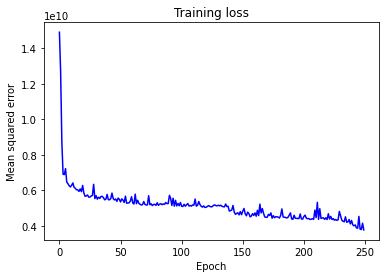

In [ ]:
plt.plot(tot_loss, 'b')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')

Text(0, 0.5, '2015 House price')

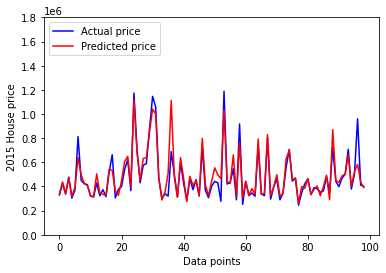

In [ ]:
p1, = plt.plot(y_test.view(-1).cpu().data.numpy()[1:100], 'b')
p2, = plt.plot(y_test_pred.cpu().data.numpy()[1:100], 'r')
axes = plt.gca()
axes.set_ylim([0,1.8e6])
plt.legend([p1, p2],["Actual price","Predicted price"], loc=2)

plt.xlabel('Data points')
plt.ylabel('2015 House price')

In [ ]:
Data['Price Increase']  = Data['Price Increase'].map({1:1, -1:0})
X_obj2 = Data.drop(['Price Increase', 'fully_taxable','Assessed Value 2016','assessed_value'], axis =1)
#,	'basement_finished',	'has_garage',	'walkout_basement', 'air_conditioning',	'valuation_group',	'site_coverage', 'assessed_value'
y_obj2 = Data.loc[:,'Price Increase'].copy()

X_train_obj2, X_test_obj2, y_train_obj2, y_test_obj2 = train_test_split(
    X_obj2, y_obj2, test_size=0.1, random_state=10)

train_dataset_obj2 = Datasetload(X_train_obj2, y_train_obj2)
train_loader_obj2 = DataLoader(train_dataset_obj2, batch_size=128, shuffle=True)

X_test_obj2 = Variable(torch.tensor(X_test_obj2.to_numpy())).float().to(device)
y_test_obj2 = Variable(torch.tensor(y_test_obj2.to_numpy())).long().to(device)


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class Model2(nn.Module):
    def __init__(self, input_dim):
        super(Model2, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x



model2 = Model2(input_dim=15).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
loss_fn2 = nn.BCELoss()

In [ ]:
EPOCHS = 250
tot_loss2 = []
accuracy_train = []
accuracy_test = []

All_loss = []

for epoch in range(EPOCHS):
  for data in train_loader_obj2:
    My_X, My_y = data
    optimizer2.zero_grad()
    y_pred = model2(My_X.view(-1, 15).float())
    new_shape = (len(y_pred), 1)
    loss = loss_fn2(y_pred.view(-1), My_y.view(-1).float()) #loss(input, target)
    All_loss.append(loss)

    loss.backward()
    optimizer2.step()
    tot_loss2.append(loss.cpu().data.numpy())


  with torch.no_grad():
    predicted = model2(Variable(torch.tensor(X_train_obj2.to_numpy())).float().to(device))
      #acc = np.mean(([predicted.reshape(-1).round() == My_y.reshape(-1)]))
    acc = np.mean((predicted.view(-1).round() == Variable(torch.tensor(y_train_obj2.to_numpy())).float().to(device).view(-1)).data.numpy())
  accuracy_train.append(acc)



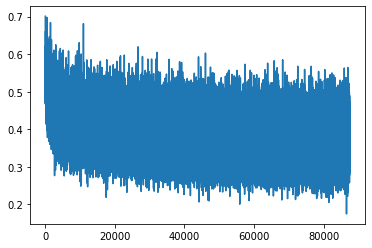

In [ ]:
plt.plot(All_loss)

Text(0, 0.5, 'Accuracy')

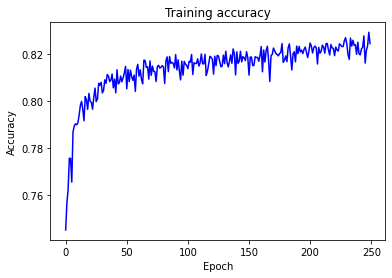

In [ ]:
plt.plot(accuracy_train, 'b')
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
predicted_test_obj2 = model2(X_test_obj2)
acc_test_obj2 = np.mean((predicted_test_obj2.view(-1).round() == y_test_obj2.view(-1)).data.numpy())
acc_test_obj2

0.8113814598833702

In [ ]:
predicted_train_obj2 = model2(Variable(torch.tensor(X_train_obj2.to_numpy())).float().to(device))
acc_train_obj2 = np.mean((predicted_train_obj2.view(-1).round() == Variable(torch.tensor(y_train_obj2.to_numpy())).float().to(device).view(-1)).data.numpy())
acc_train_obj2

0.8244665400513909

In [ ]:
predicted_test_obj2

tensor([[0.3566],
        [0.6281],
        [0.6516],
        ...,
        [0.1017],
        [0.9926],
        [0.1177]], grad_fn=<SigmoidBackward0>)

In [ ]:
torch.save(model, "model_obj2_100_with2.pt")
#model = torch.load("model_obj1_100.pt")

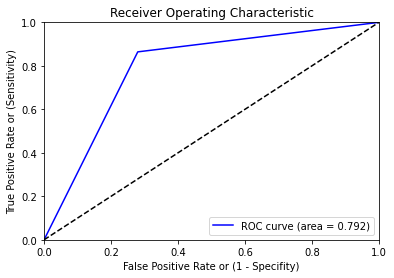

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_obj2.view(-1).data.numpy(), predicted_test_obj2.view(-1).round().data.numpy())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, color='b')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#helped from stackoverflow.com

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

EPOCHS = 250

acc_k_all = []

accuracy_train = []

All_loss = []

tot_loss2 = []

for train_index, test_index in kfold.split(X_train_obj2):
  Xi_train_kfold, Xi_test_kfold = X_train_obj2.iloc[train_index,:], X_train_obj2.iloc[test_index,:]

  yi_train_kfold, yi_test_kfold = y_train_obj2.iloc[train_index], y_train_obj2.iloc[test_index]

  train_dataset_kfold = Datasetload(Xi_train_kfold, yi_train_kfold)
  train_loader_kfold = DataLoader(train_dataset_kfold, batch_size=128, shuffle=True)

  Xi_test_kfold  = Variable(torch.tensor(Xi_test_kfold.to_numpy())).float().to(device)
  yi_test_kfold  = Variable(torch.tensor(yi_test_kfold.to_numpy())).long().to(device)


  for epoch in range(EPOCHS):
    for data in train_loader_kfold:
      My_X, My_y=data

      My_X, My_y = data
    optimizer2.zero_grad()
    y_pred = model2(My_X.view(-1, 15).float())
    #new_shape = (len(y_pred), 1)
    loss = loss_fn2(y_pred.view(-1), My_y.view(-1).float()) #loss(input, target)
    All_loss.append(loss)

    loss.backward()
    optimizer2.step()
    tot_loss2.append(loss.cpu().data.numpy())


  with torch.no_grad():
    predicted = model2(Variable(torch.tensor(X_train_obj2.to_numpy())).float().to(device))
      #acc = np.mean(([predicted.reshape(-1).round() == My_y.reshape(-1)]))
    acc2 = np.mean((predicted.view(-1).round() == Variable(torch.tensor(y_train_obj2.to_numpy())).float().to(device).view(-1)).data.numpy())
  accuracy_train.append(acc2)


  y_test_pred_K = model2(Xi_test_kfold)
  acc = np.mean((y_test_pred_K.view(-1).round() == yi_test_kfold.view(-1)).data.numpy())

  acc_k_all.append(acc)



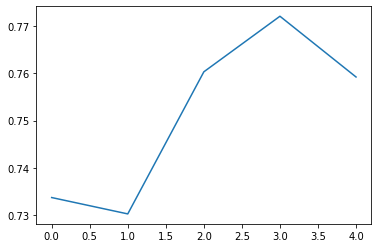

In [ ]:
plt.plot(accuracy_train)

In [ ]:
acc_k_all

[0.7231594235280974,
 0.7424868729750865,
 0.7603619707295274,
 0.7572338286225003,
 0.7686292034409563]

In [ ]:
np.mean(acc_k_all)

0.7503742598592336

# Data Exploration
Determine (graphically) if there are any obvious relationships in the data that could help us decide which variables to include in our model.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
hist = pd.read_csv('Property_Assessment_Data__Historical_.csv') # Historical data.
re_data = pd.read_csv('EdmontonRealEstateData.csv') # Real estate (main) data.

In [ ]:
hist_2016 = hist[hist['Assessment Year'] == 2016][['Account Number', 'Assessed Value']].rename(columns={'Assessed Value': 'Assessed Value 2016'})
hist_2016 = hist_2016.set_index('Account Number')
re_data_ext = re_data.set_index('taxroll_number').join(hist_2016) # The data now contains a column for the assessed value in 2016.

In [ ]:
Data = re_data_ext[['property_type', 'effective_build_year', 'net_area', 'basement_finished', 'has_garage', 'has_fireplace',
                            'assessed_value','fully_taxable', 'walkout_basement' ,'air_conditioning', 'valuation_group',
                    'display_type', 'site_coverage','lon', 'lat','Assessed Value 2016']]

Data.dropna(inplace=True)
Data = Data.loc[(Data['property_type']=='RESIDENTIAL') & (Data['display_type']=='RES')]
Data.drop(['property_type', 'display_type'], axis =1, inplace=True)

In [ ]:
'''
# removing outliers
z= np.abs(stats.zscore(Data['assessed_value'])) # Utilizing zscore to remove outliers
filtered_df = (z < 3) # Removing values with zscore greater than 3 standard deviation
Data = Data[filtered_df] # Filtered data set with removed outliers

#Normalizing data
scaler = MinMaxScaler()
numerical = Data.select_dtypes(include='float64').columns
Data.loc[:,numerical]=scaler.fit_transform(Data.loc[:,numerical])
'''

In [ ]:
# Using label encoding to convert categorical variables to factors/nominal variables.

Data['Basement_encoded']  = LabelEncoder().fit_transform(Data['basement_finished'])
Data['Garage_encoded']    = LabelEncoder().fit_transform(Data['has_garage'])
Data['fireplace_encoded'] = LabelEncoder().fit_transform(Data['has_fireplace'])
Data['Walkoutbase_encod'] = LabelEncoder().fit_transform(Data['walkout_basement'])
Data['AC_encoded']        = LabelEncoder().fit_transform(Data['air_conditioning'])
Data['ftaxable_encoded']  = LabelEncoder().fit_transform(Data['fully_taxable'])
Data['valgroup_encoded']  = Data['valuation_group'].map({'RESIDENTIAL SOUTH':0, 'RESIDENTIAL NORTH':1, 'RESIDENTIAL WC':2,
       'RESIDENTIAL RIVVAL':3, 'SPECIAL PURPOSE':4, 'LAND': 5, 'RESIDENTIAL LAND':6})

Data.head()

,effective_build_year,net_area,basement_finished,has_garage,has_fireplace,assessed_value,fully_taxable,walkout_basement,air_conditioning,valuation_group,site_coverage,lon,lat,Assessed Value 2016,Price Increase,Basement_encoded,Garage_encoded,fireplace_encoded,Walkoutbase_encod,AC_encoded,ftaxable_encoded,valgroup_encoded
taxroll_number,,,,,,,,,,,,,,,,,,,,,,
10195786,0.972477,0.073980,Yes,Yes,Yes,0.036054,Yes,NO,NO,RESIDENTIAL SOUTH,0.384615,0.676753,0.091337,0.036413,1,1,1,1,0,0,1,0
10195785,0.972477,0.069563,NO,Yes,Yes,0.033908,Yes,NO,NO,RESIDENTIAL SOUTH,0.446154,0.676182,0.091209,0.034189,1,0,1,1,0,0,1,0
10195784,0.972477,0.069689,NO,Yes,Yes,0.034330,Yes,NO,NO,RESIDENTIAL SOUTH,0.476923,0.675737,0.091176,0.034528,1,0,1,1,0,0,1,0
10195783,0.963303,0.071582,NO,Yes,Yes,0.034291,Yes,NO,NO,RESIDENTIAL SOUTH,0.507692,0.675348,0.091171,0.035282,1,0,1,1,0,0,1,0
10195782,0.963303,0.082310,NO,Yes,Yes,0.035977,Yes,NO,NO,RESIDENTIAL SOUTH,0.523077,0.674956,0.091159,0.036149,1,0,1,1,0,0,1,0


In [ ]:
data_clean = Data[['effective_build_year', 'net_area','assessed_value','site_coverage',	'lon','lat', 'valgroup_encoded',
                  'Basement_encoded',	'Garage_encoded',	'fireplace_encoded', 'Walkoutbase_encod',	'AC_encoded',	'ftaxable_encoded', 'Assessed Value 2016']]

data_clean.head()

,effective_build_year,net_area,assessed_value,site_coverage,lon,lat,valgroup_encoded,Basement_encoded,Garage_encoded,fireplace_encoded,Walkoutbase_encod,AC_encoded,ftaxable_encoded,Assessed Value 2016
taxroll_number,,,,,,,,,,,,,,
10195786,0.972477,0.073980,0.036054,0.384615,0.676753,0.091337,0,1,1,1,0,0,1,0.036413
10195785,0.972477,0.069563,0.033908,0.446154,0.676182,0.091209,0,0,1,1,0,0,1,0.034189
10195784,0.972477,0.069689,0.034330,0.476923,0.675737,0.091176,0,0,1,1,0,0,1,0.034528
10195783,0.963303,0.071582,0.034291,0.507692,0.675348,0.091171,0,0,1,1,0,0,1,0.035282
10195782,0.963303,0.082310,0.035977,0.523077,0.674956,0.091159,0,0,1,1,0,0,1,0.036149


In [ ]:
data_clean.dtypes

effective_build_year    float64
net_area                float64
assessed_value          float64
site_coverage           float64
lon                     float64
lat                     float64
valgroup_encoded          int64
Basement_encoded          int64
Garage_encoded            int64
fireplace_encoded         int64
Walkoutbase_encod         int64
AC_encoded                int64
ftaxable_encoded          int64
Assessed Value 2016     float64
dtype: object

In [ ]:
# Some type conversion.
data_clean.loc[:, 'effective_build_year'] = data_clean['effective_build_year'].astype('int64')
data_clean.loc[:, 'assessed_value'] = data_clean['assessed_value'].astype('float64')
# The below line seems overly complicated but gets rid of the comma so that we can convert from type object to a float.
data_clean.loc[:, 'Assessed Value 2016'] = data_clean.loc[:, 'Assessed Value 2016'].apply(lambda x: float(x.replace(',','')))

In [ ]:
data_clean.dtypes

effective_build_year      int64
net_area                float64
assessed_value          float64
site_coverage           float64
lon                     float64
lat                     float64
valgroup_encoded          int64
Basement_encoded          int64
Garage_encoded            int64
fireplace_encoded         int64
Walkoutbase_encod         int64
AC_encoded                int64
ftaxable_encoded          int64
Assessed Value 2016     float64
dtype: object

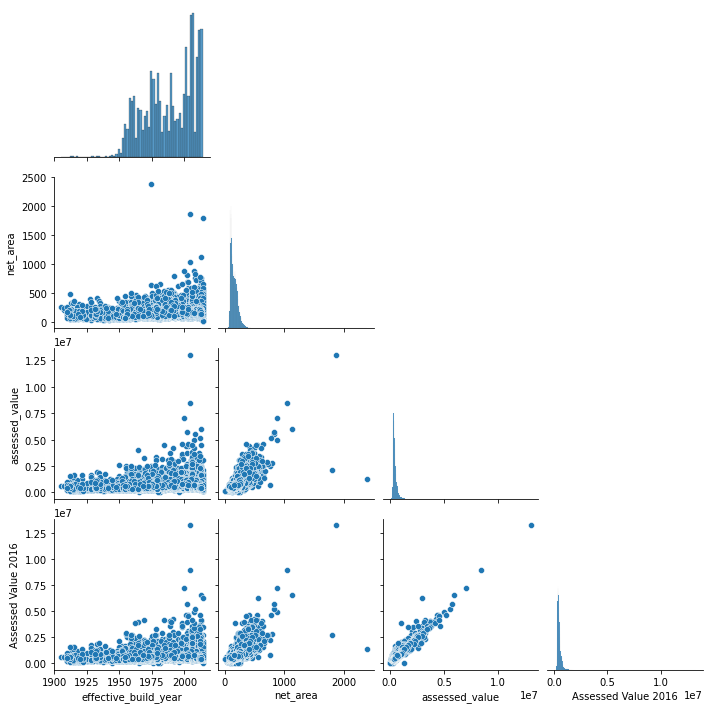

In [ ]:
sns.pairplot(data_clean[['effective_build_year', 'net_area', 'assessed_value', 'Assessed Value 2016']], corner = True)

In [ ]:
corr = data_clean[['effective_build_year', 'net_area', 'assessed_value', 'Assessed Value 2016']].corr()

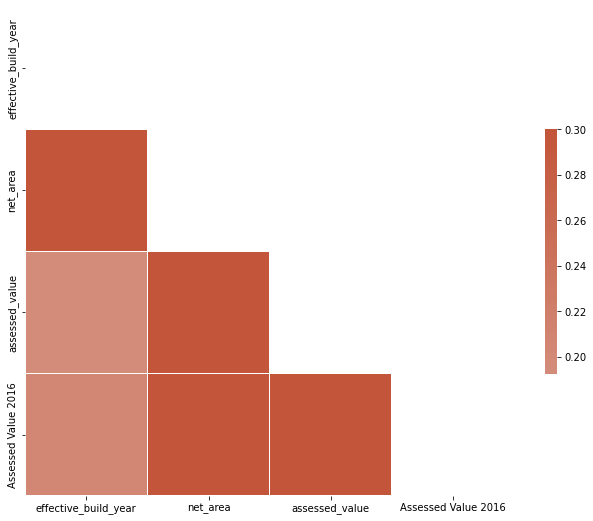

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})